Author: 

Rebecka Fahrni (18-735-522)

# Exercise 5

## Instructions

- Make sure you have uploaded the audio files to Google Drive.
- Please read the markdown sections, and code comments carefully before answering.
- You are required to treat ``...`` as incomplete code, which you are required to complete.
- Each incomplete region marked by ``...`` can be completed with a maximum of 2 statements (2 lines of code in Python).
- You may refer to the slides and reference material, but may not use AI code completion.
- Run all code cells in the notebook even if it does not require any answer from your part.
- The point for each section or sub-section is given in square brackets. E.g [15 pt] means 15 points.
- Pay attention to Q. & A. questions. The markdown-python cell separation is not always obvious.
- **ATTENTION**: There are many places where the path of the audio file needs to be fixed by you.

In [65]:
# mount google drive
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [66]:
#!pip install git+https://github.com/openai/whisper.git

In [67]:
#!pip install jiwer

In [68]:
# jiwer example usage
import jiwer
reference = "hello world"
hypothesis = "hello duck"

error = jiwer.wer(reference, hypothesis)
error


0.5

In [69]:
character_error = jiwer.cer(reference, hypothesis)
character_error

0.45454545454545453

In [70]:
import warnings
warnings.filterwarnings("ignore")

## 1. Word Error Rate (20pt)

Questions:

1. Use jiwer to get WER and CER between the following hypothesis and reference (5)?

In [71]:
ref = 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE'
hyp = 'HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOWER FATTEN SAUCE'
wer = jiwer.wer(ref, hyp)
cer = jiwer.cer(ref, hyp)

2. Give example of an ASR output with WER 10% with only one of the following errors: insertions, deletions, or substitutions w.r.t the following reference? (5)

Reference is:

THE DARK SUIT WAS IN GREASY WASH WATER ALL YEAR


----
Answer: so the total number of words in the reference is 10. So, 10% of 10 is 1 word error. So, the hypothesis should have 9 words correct and 1 word error. The error can be either insertion, deletion, or substitution.
For example, the hypothesis can be: 

- for an inserion error, THE DARK SUIT WAS IN GREASY WASH WATER ALL YEAR QUICKLY (added one word), 

- for a deletion error: THE DARK SUIT WAS IN GREASY WASH WATER ALL (deleted one word), 

- for a substitution error: THE DARK SUIT WAS IN GREASY WASH WATER ALL MONTH (substituted one word/ year by month).


3.  Give example of an ASR output with WER 150% w.r.t the following reference? (5)

Reference is:

THE DARK SUIT WAS IN GREASY WASH WATER ALL YEAR

---
Answer: so the total number of words in the reference is 10. So, 150% of 10 is 15 word errors.
So, in the case of an all insertion error, the hypothesis length is calculated as 10+15=25 words. The hypothesis can be:

THE DARK SUIT WAS IN GREASY WASH WATER ALL YEAR SUDDENLY QUICKLY RANDOMLY APPEARED AGAIN

in the case of combination of deletion, substitution, and insertion errors, the hypothesis can have also a hypothesis lenght of 8. Where the errors can be (6 substitutions, 4 deletions, 5 insertions):
then the hypothesis can be:
DARK SUIT WAS IN GREASY WASH WATER ALL YEAR SUDDENLY QUICKLY RANDOMLY APPEARED AGAIN (and be still have a WER of 150%)


4. A dataset has 10 speech utterances. We are also given reference text for each of those 10 utterances. Given only WER of an ASR system for each of the 10 utterances (i.e. we do not have access to the hypothesis of the ASR system), how can we calculate the WER on the entire dataset ? (5)

---
Answer:  overall WER for the dataset is computed as total number of edit errors across all utterances divided by the total number of words in references for all utterances. Since we are given only the WER for each utterance - use formula:
$$
\text{WER}_{\text{dataset}} = \frac{\sum_{i=1}^{10} (\text{WER}_i \times R_i)}{\sum_{i=1}^{10} R_i}
$$
with:
- $( R_i)$ is the total number of words in the reference for utterance $( i)$.  
- $( \text{WER}_i)$ is the WER for utterance $( i)$.  
- $( \text{WER}_i \times R_i)$ gives the total edit errors for utterance $( i )$.

so the steps are as follows:
1. for each utterance $( i)$, multiply $( \text{WER}_i)$ (expressed as a fraction) by $( R_i)$ to calculate total edit errors.  
2. sum total edit errors for all $( 10 )$ utterances.  
3. sum  total number of words in all references $(( \sum_{i=1}^{10} R_i ))$.  
4. Divide the total edit errors by the total reference words to get the overall WER.

for example:
- $( R_1 = 10, WER_1 = 0.2 )$ (20%)  
- $( R_2 = 15, WER_2 = 0.1 )$ (10%)  
- $( \ldots )$  
- $( R_{10} = 8, WER_{10} = 0.3 )$ (30%)  
then the total edit errors across all utterances is:
$$
\text{Edit Errors}_\text{total} = (0.2 \times 10) + (0.1 \times 15) + \ldots + (0.3 \times 8)
$$

and the total reference words:
$$
\text{Words}_\text{total} = R_1 + R_2 + \ldots + R_{10}
$$

so dataset WER:
$$
\text{WER}_{\text{dataset}} = \frac{\text{Edit Errors}_\text{total}}{\text{Words}_\text{total}}
$$



## 2. Decoding with Whisper

In this section we will decode with the [AMI dataset](https://groups.inf.ed.ac.uk/ami/corpus/). We will use a subset of the test split of the dataset. We will use the term "AMI test" to refer to this set.

There are three tasks in this section:

1. Decode on AMI test with default parameters and evaluate the model's performance.
2. Decode on AMI test with beam search with beam size 4 and evaluate the model's performance.
3. Evaluate WER before and after text normalization

## 2.1 Example usage

In [72]:
import os
path = os.getcwd()
audio_dir = path +'/ami-en2002b/ami-en2002b'

In [73]:
from whisper import load_model
model = load_model('small', device='cpu', download_root='./')
# Whisper uses a greedy decoder when no option is specified.
#result_greedy = model.transcribe("/content/drive/MyDrive/work/uzh/teaching/2024-speech-technology/audio_files_ex5/ami-en2002b/EN2002b-3-379-ihm.wav", language="en", temperature=0)
test_audio = audio_dir+ '/EN2002b-3-379-ihm.wav'
result_greedy = model.transcribe(test_audio, language="en", temperature=0)
result_greedy['text']  # way to access hypothesis after decoding


' Well, I thought you had tomorrow.'

## 2.2 Whisper decoding (5 pt)

In [74]:
utt2ref = {}
# TODO: fix path
with open(audio_dir+ '/text_random150') as ipf:
  for ln in ipf:
    utt, *text = ln.strip().split()
    utt2ref[utt] = " ".join(text)

In [75]:
# Decode with default settings (greedy decoding)
utt2hyp = {}
# for each utterance in utt2ref, decode and store the result in utt2hyp[utt]
for utt in utt2ref:
    audio_path = os.path.join(audio_dir, f"{utt}.wav")
    if os.path.exists(audio_path):  
        result = model.transcribe(audio_path, language="en", temperature=0)
        utt2hyp[utt] = result['text']
    else:
        print(f"WARNING: Audio file not found for utterance {utt}")

In [76]:
results = []
for utt in utt2ref:
  if utt not in utt2hyp:
    print(f"ERROR: Missing hypothesis for utt {utt}")
    break
  results.append((utt, utt2ref[utt].split(), utt2hyp[utt].split()))
results[0] # example showing what results contains

('EN2002b-1-170-ihm',
 ['GOALS', 'OR', 'SOMETHING'],
 ['goals', 'or', 'something.'])

In [77]:
# now using Beam Search: 
# Decode with beam search decoding (beam size 4)
utt2hyp_beam = {}
for utt in utt2ref:
    audio_path = os.path.join(audio_dir, f"{utt}.wav")
    if os.path.exists(audio_path): 
        result_beam = model.transcribe(audio_path, language="en", beam_size=4)
        utt2hyp_beam[utt] = result_beam['text']
        
results_beam = []
for utt in utt2ref:
  if utt not in utt2hyp_beam:
    break
  results_beam.append((utt, utt2ref[utt].split(), utt2hyp_beam[utt].split()))
results_beam[0]


('EN2002b-1-170-ihm',
 ['GOALS', 'OR', 'SOMETHING'],
 ['goals', 'or', 'something.'])

In [78]:
#!pip install kaldialign

In [79]:
# DO NOT MODIFY THIS CODE
# Code modified from Icefall: https://github.com/k2-fsa/icefall/blob/master/icefall/utils.py
# Copyright      2021  Xiaomi Corp.        (authors: Fangjun Kuang,
#                                                    Mingshuang Luo,
#                                                    Zengwei Yao)
#
# See ../../LICENSE for clarification regarding multiple authors
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from collections import defaultdict
import kaldialign
from typing import Dict, Tuple, List

def get_error_stats(
    results: List[Tuple[str, str]],
    compute_CER: bool = False,
) -> float:
    """Write statistics based on predicted results and reference transcripts.

    It will write the following to the given file:

        - WER
        - number of insertions, deletions, substitutions, corrects and total
          reference words. For example::

              Errors: 23 insertions, 57 deletions, 212 substitutions, over 2606
              reference words (2337 correct)

        - The difference between the reference transcript and predicted result.
          An instance is given below::

            THE ASSOCIATION OF (EDISON->ADDISON) ILLUMINATING COMPANIES

          The above example shows that the reference word is `EDISON`,
          but it is predicted to `ADDISON` (a substitution error).

          Another example is::

            FOR THE FIRST DAY (SIR->*) I THINK

          The reference word `SIR` is missing in the predicted
          results (a deletion error).
      results:
        An iterable of tuples. The first element is the cut_id, the second is
        the reference transcript and the third element is the predicted result.
      enable_log:
        If True, also print detailed WER to the console.
        Otherwise, it is written only to the given file.
    Returns:
      Return None.
    """
    subs: Dict[Tuple[str, str], int] = defaultdict(int)
    ins: Dict[str, int] = defaultdict(int)
    dels: Dict[str, int] = defaultdict(int)

    # `words` stores counts per word, as follows:
    #   corr, ref_sub, hyp_sub, ins, dels
    words: Dict[str, List[int]] = defaultdict(lambda: [0, 0, 0, 0, 0])
    num_corr = 0
    ERR = "*"

    for cut_id, ref, hyp in results:
        ali = kaldialign.align(ref, hyp, ERR, sclite_mode=False)
        for ref_word, hyp_word in ali:
            if ref_word == ERR:
                ins[hyp_word] += 1
                words[hyp_word][3] += 1
            elif hyp_word == ERR:
                dels[ref_word] += 1
                words[ref_word][4] += 1
            elif hyp_word != ref_word:
                subs[(ref_word, hyp_word)] += 1
                words[ref_word][1] += 1
                words[hyp_word][2] += 1
            else:
                words[ref_word][0] += 1
                num_corr += 1
    ref_len = sum([len(r) for _, r, _ in results])
    sub_errs = sum(subs.values())
    ins_errs = sum(ins.values())
    del_errs = sum(dels.values())
    tot_errs = sub_errs + ins_errs + del_errs
    tot_err_rate = "%.2f" % (100.0 * tot_errs / ref_len)


    print(
        f"%WER {tot_errs / ref_len:.2%} "
        f"[{tot_errs} / {ref_len}, {ins_errs} ins, "
        f"{del_errs} del, {sub_errs} sub ]"
    )

    print(f"%WER = {tot_err_rate}")
    print(
        f"Errors: {ins_errs} insertions, {del_errs} deletions, "
        f"{sub_errs} substitutions, over {ref_len} reference "
        f"words ({num_corr} correct)",
    )
    print(
        "Search below for sections starting with PER-UTT DETAILS:, "
        "SUBSTITUTIONS:, DELETIONS:, INSERTIONS:, PER-WORD STATS:",
    )

    print("")
    print("PER-UTT DETAILS: corr or (ref->hyp)  ")
    for cut_id, ref, hyp in results:
        ali = kaldialign.align(ref, hyp, ERR)
        combine_successive_errors = True
        if combine_successive_errors:
            ali = [[[x], [y]] for x, y in ali]
            for i in range(len(ali) - 1):
                if ali[i][0] != ali[i][1] and ali[i + 1][0] != ali[i + 1][1]:
                    ali[i + 1][0] = ali[i][0] + ali[i + 1][0]
                    ali[i + 1][1] = ali[i][1] + ali[i + 1][1]
                    ali[i] = [[], []]
            ali = [
                [
                    list(filter(lambda a: a != ERR, x)),
                    list(filter(lambda a: a != ERR, y)),
                ]
                for x, y in ali
            ]
            ali = list(filter(lambda x: x != [[], []], ali))
            ali = [
                [
                    ERR if x == [] else " ".join(x),
                    ERR if y == [] else " ".join(y),
                ]
                for x, y in ali
            ]

        print(
            f"{cut_id}:\t"
            + " ".join(
                (
                    ref_word if ref_word == hyp_word else f"({ref_word}->{hyp_word})"
                    for ref_word, hyp_word in ali
                )
            ),
        )

    print("")
    print("SUBSTITUTIONS: count ref -> hyp")

    for count, (ref, hyp) in sorted([(v, k) for k, v in subs.items()], reverse=True):
        print(f"{count}   {ref} -> {hyp}")

    print("")
    print("DELETIONS: count ref")
    for count, ref in sorted([(v, k) for k, v in dels.items()], reverse=True):
        print(f"{count}   {ref}")

    print("")
    print("INSERTIONS: count hyp")
    for count, hyp in sorted([(v, k) for k, v in ins.items()], reverse=True):
        print(f"{count}   {hyp}")

    print("")
    print("PER-WORD STATS: word  corr tot_errs count_in_ref count_in_hyp")
    for _, word, counts in sorted(
        [(sum(v[1:]), k, v) for k, v in words.items()], reverse=True
    ):
        (corr, ref_sub, hyp_sub, ins, dels) = counts
        tot_errs = ref_sub + hyp_sub + ins + dels
        ref_count = corr + ref_sub + dels
        hyp_count = corr + hyp_sub + ins

        print(f"{word}   {corr} {tot_errs} {ref_count} {hyp_count}")
    return float(tot_err_rate)

Run the above code. Check the most common errors (insertion, substituion, deletion) and propose some methods to fix the issue.

In [ ]:
get_error_stats(results)

In [ ]:
get_error_stats(results_beam)

**Answer:** Obersvations and Proposed Methods to Fix Decoding Issues

**1. Observations**
1. **Default Decoding: greedy Search**:
   - Lower Word Error Rate (WER: 100.00%) but with notable **substitutions (872)**, **deletions (127)**, and **insertions (28)**
   - Fewer insertion and substitution errors than beam search.
   - Higher deletion errors compared to beam search.
   - **Common Errors:**
      - **Substitution Example:** `(YEAH → Thank you)`  
      - **Deletion Example:** `(YOU → ∅)`  
      - **Insertion Example:** `(∅ → you.)`  
2. **Beam Search**:
   - Slightly higher WER (\~101.56%).
   - Fewer deletions but increased insertions and substitutions.
   - Slight improvement in word inclusion (one additional correct word).


**2. Proposed Fixes**

- Reduce Substitution Errors:
   - **Observation:** Many substitutions occur with casual terms like *"Yeah,"* *"You,"* and *"Okay."*

   - **Fine-tune Language Model on Conversational Data**
   - *Example Fix:* `(YEAH → Yeah)` instead of `(YEAH → Thank you)`
   - one could train the model specifically on AMI meeting datasets.

   - **Context-Aware Decoding**
   - *Example Fix:* `(OH SHE HAS → Oh, she has)` instead of `(OH SHE HAS → Oh, shit)`
   - so use a context-aware decoder to consider surrounding sentence structure.

- Reduce Deletion Errors:
   - **Observation:** Frequent deletions of shorter words (*"you"*, *"it"*, *"well"*) impact comprehension.

   - **Adjust Confidence Thresholds**
   - *Example Fix:* `(YOU → you)` instead of omitting "YOU."
   - so one could  retain low-confidence predictions if they are likely to be meaningful.

Reduce Insertion Errors:
   - **Observation:** Insertions like `you.` or `something.` degrade sentence clarity.

   - **Adjust Beam Size**
   - *Example Fix:* `(∅ → you.)` avoided by using a smaller beam size.
   - one could experiment with beam sizes (e.g., reduce from 4 to 3/2).

- **Length Penalty in Decoding**
   - *Example Fix:* `(OH → No)` instead of generating unnecessary words.
   - one could also maybe apply penalties for overly verbose outputs.

Post-Processing with Heuristics:
   - **Rule-Based Post-Processing**
   - *Example Fix:* Remove repetitive outputs like `(MM → *)`.
   - by maybe applying regex-based rules to clean outputs.

   - **Error Correction Module**
   - *Example Fix:* Replace hallucinated outputs like `(SNORE → Star)` with more plausible predictions.
   - one could use an external correction layer trained on common AMI transcription errors.

   - **Fine-Tuning**:
   - one could also try to fine-tune the model on AMI meeting data to improve performance on this specific domain( meetings).

---

### Text normalization (20 pt)

Whisper outputs human readable text by default. Notice that the this is not the case for reference.

Normalize the reference and/or hypothesis text output in a way that both of them match. Then compute the WER again with ``get_error_stats()``.

You may Google for any Python-relevant help for string processing. If you use an external reference, please add the reference in the comment.

You may reuse code from previous sections to compute WER.


In [82]:
# Enter your code here. You can use multiple cells if necessary.
# Code "may" be longer than 3 statements in this case.
import spacy # using spaCy library
from cleantext import clean # using clean-text library
from jiwer import wer
import re

nlp = spacy.load('en_core_web_sm')

replacement_dict = {
    "uh": "", "um": "", "mm-hmm": "yes", "mm": "", "hmm": "", "'cause": "because",
    "yeah": "yes", "okay": "ok", "okey": "ok", "uh-huh": "yes", "uh-huh.": "yes",
    "gonna": "going to", "wanna": "want to", "kinda": "kind of", "lemme": "let me",
    "gotta": "got to", "ain't": "is not", "y'all": "you all", "n't": " not",
    "it's": "it is", "i'm": "i am", "you're": "you are", "they're": "they are",
    }

def replace_with_dict(text, replacements):
    for key, value in replacements.items():
        text = re.sub(rf'\b{key}\b', value, text, flags=re.IGNORECASE)
    return text


def normalize_text(text):
    """
    Normalize text using spaCy and clean-text.
    """
    #Clean text - clean-text libary
    text = clean(text,
        lower=True,
        no_punct=True,
        no_numbers=False,
        replace_with_punct="",
        replace_with_url="",
        replace_with_email="",
        replace_with_number="",
        lang="en")
    # Step 2: Apply custom replacements
    text = replace_with_dict(text, replacement_dict)
    text = re.sub(r'\s+', ' ', text).strip()
    #tokenize/process - spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_punct]
    normalized_text = " ".join(tokens).strip()
    return normalized_text


In [83]:

results = []
for utt in utt2ref:
    if utt not in utt2hyp:
        print(f"ERROR: Missing hypothesis for utt {utt}")
        continue
    ref_tokens = normalize_text(utt2ref[utt])
    hyp_tokens = normalize_text(utt2hyp[utt])
    
    results.append((utt, ref_tokens, hyp_tokens))

results[0] # example showing what results contains

('EN2002b-1-170-ihm', 'goals or something', 'goals or something')

In [ ]:
get_error_stats(results)


## 2.5 Error analysis (5 pt)

Pick two specific types of errors and discuss how we can improve the ASR for such errors. Note that we are not referring to INSERTION, DELETION and SUBSTITUTION errors, but something more specific. For instance, you could mention a particular error like 'TWO -> TO' and propose a remedy. Choose the ASR output with the best WER so far for your analysis.

---
Answer:
With a WER of 17.67%, the ASR system has shown significant improvement. However, certain error patterns still persist. Two specific types of errors that can be addressed are:

**Obersvation:**
- Example error 1 : EN2002b-0-36-ihm:	(h e->i t) ... (so maybe: reference: he does not have to know exactly, hypothesis: it does not have to know exactly)
- Example error 2 : EN2002b-3-2-ihm: (c->t) h a n (n e l->k y o u) ...  ( so maybe: reference: channel you, hypothesis: thank you)
- Example error 3 : EN2002b-3-168-ihm: ... (*->b e) c a u s e i m s u r e ...( referece could be: cause I'm sure you've probably made some changes already, hypothesis: because I'm sure you've probably made some changes already)
- Example error 4: EN2002b-3-14-ihm: (o h s h (e h a s → i t)) ... (so maybe: reference: oh she has, hypothesis: oh it)

**Disscussion on Imporvement and Causes:**
- In example 4, the model struggles with acoustic ambiguity. Fillers like "oh", "um", and "uh" have low phonetic energy and are often misinterpreted as content words.
Instead of deprioritizing fillers, the language model (LM) interprets them as noise rather than meaningful words. To impove this one could introduce explicit filler tokens in the LM training data to help the model distinguish between fillers and content words. one could also try to use a disfluency detection module to identify and filter out fillers before decoding.
- in exaple error 1 , the pronoun "he" is replaced with "it" due to contextual ambiguity and phonetic similarity.
Similarly, in Example 3, the substitution "cause" becomes "because"—likely due to LM bias towards more frequent grammatical structures. To address this one could use a context-aware language model (BERT/GPT) that can better capture pronoun dependencies and sentence structure. one could also try to use a speaker-aware LM to adapt to individual speaking styles and improve pronoun resolution.
- In example 2, the substitution of "channel" with "thank" highlights phonetic overlap. Short, low-energy words with similar phonetic patterns are prone to errors especially in spontaneous speech. One could address this by doing a phoneme-aware fine-tuning to better handle phonetic similar words or could trian ASR system on spontaneous speech dataset where similar overlaps frequently occur.

### 2.6 Plot WER vs utterance duration (10pt)

Create a plot to check if the duration of the utterance is related to the WER. Conclude upon visual observation if there exists a correlation between the two quantities. Use the system with the best WER so far. Justify your response.

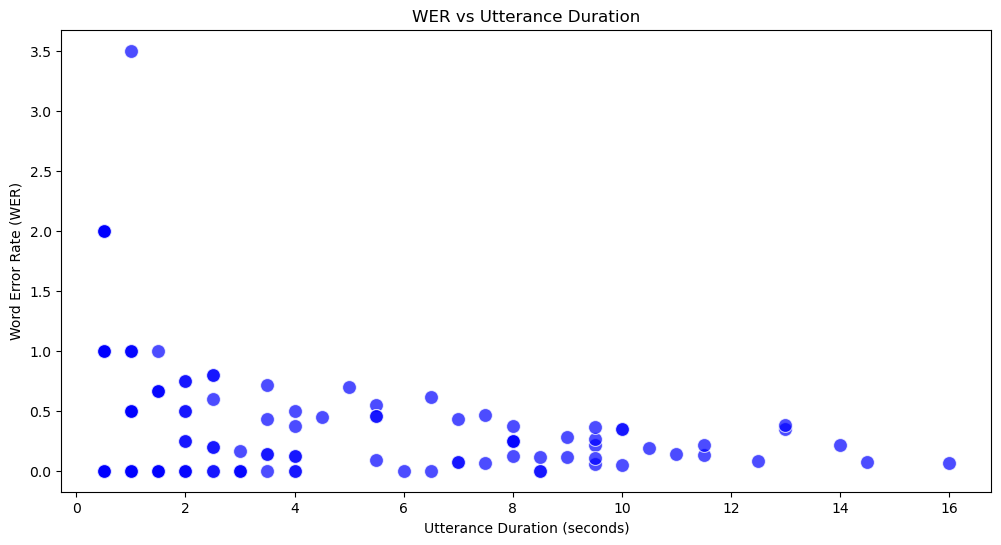

Correlation Coefficient: -0.17643302666339505


In [85]:
# Convert to DataFrame
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import jiwer

df = pd.DataFrame(results, columns=["utterance", "ref", "hyp"])

df = df[(df['ref'] != '') & (df['hyp'] != '')] # remove empty utterances (if any)
df['WER'] = df.apply(lambda row: jiwer.wer(row['ref'], row['hyp']), axis=1)
df['duration'] = df['ref'].apply(lambda x: len(x.split()) * 0.5) # approx. utterance duration (0.5s per word in reference)

#df.head()
#plot 
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='duration', y='WER', s=100, color='b', alpha=0.7)
plt.title('WER vs Utterance Duration')
plt.xlabel('Utterance Duration (seconds)')
plt.ylabel('Word Error Rate (WER)')
plt.show()

correlation = df['duration'].corr(df['WER'])
print(f"Correlation Coefficient: {correlation}") # weak correlation

Observation: 
From the visual observation, there is no clear positive correlation between utterance duration and WER. However:
- Short utterances show higher variability in WER, with occasional extreme outliers.
- Longer utterances tend to have lower and more consistent WER values, possibly because they provide more acoustic context for the ASR system to perform accurate predictions.

These findings suggest that utterance length alone does not strongly dictate WER, but shorter utterances are more prone to variability in recognition performance, likely due to insufficient acoustic context or ambiguity in phonetic content.

## 3. Whisper tokenizer (15pt)

In the next code cell, the tokenizer used by multilingual models is initialized in the variable ``tokenizer``. Without changing the ``tokenizer`` variable, do the following:

1. Print the token index of beginning of sentence and end of sentence special tokens
2. Based on [this dictionary](https://github.com/openai/whisper/blob/90db0de1896c23cbfaf0c58bc2d30665f709f170/whisper/tokenizer.py#L10), print the the token index of two languages: French and German. An example is already given below for English.
3. Given that the supported languages are in ``whisper.tokenizer.LANGUAGES``, find out only using python code if (a) your native tongue is supported (b) the language Kurmanji is supported.

In [86]:
from whisper import load_model

model = load_model('base', device='cpu', download_root='./')

100%|███████████████████████████████████████| 139M/139M [00:29<00:00, 4.85MiB/s]


In [87]:
import whisper.tokenizer as whisper_tokenizer

tokenizer = whisper_tokenizer.get_tokenizer(
    True,  # assume a multilingual model
    num_languages=model.num_languages,
)

In [88]:
## 1. Print the token index of bos, eos (2.5 pt)
bos_token_index = tokenizer.special_tokens.get('<|startoftranscript|>')
eos_token_index = tokenizer.special_tokens.get('<|endoftext|>')

print("1. Special Tokens:")
print(f"Token index for Beginning of Sentence (BOS): {bos_token_index}")
print(f"Token index for End of Sentence (EOS): {eos_token_index}")

1. Special Tokens:
Token index for Beginning of Sentence (BOS): 50258
Token index for End of Sentence (EOS): 50257


In [89]:
# This is an example to get the language token for English.
tokenizer.special_tokens.get('<|en|>')

50259

In [90]:
## 2. print the the token index of French and German (2.5 pt)
french_token_index = tokenizer.special_tokens.get('<|fr|>')
german_token_index = tokenizer.special_tokens.get('<|de|>')

print("\n2. Language Tokens:")
print(f"Token index for French: {french_token_index}")
print(f"Token index for German: {german_token_index}")


2. Language Tokens:
Token index for French: 50265
Token index for German: 50261


In [91]:
## 3. Find out only using python code if (a) your native tongue is supported (b) the language Kurmanji is supported. (10 pt)
print("\n3. Language Support Check:")
# a) Check if Swedish is supported : Checked first if SwissGerman but that is not supported
native_language = 'swiss' 
is_native_supported = native_language in whisper_tokenizer.LANGUAGES
print(f"Is SwissGerman tongue ('{native_language}') supported? {'Yes' if is_native_supported else 'No'}")
native_language = 'sv' # SwissGerman is not supported  swedish is
is_native_supported = native_language in whisper_tokenizer.LANGUAGES
print(f"Is Swedish tongue ('{native_language}') supported? {'Yes' if is_native_supported else 'No'}")

# b) Check if Kurmanji is supported
is_kurmanji_supported = 'ku' in whisper_tokenizer.LANGUAGES  # 'ku' is the ISO 639-1 code for Kurdish
print(f"Is Kurmanji ('ku') supported? {'Yes' if is_kurmanji_supported else 'No'}")


3. Language Support Check:
Is SwissGerman tongue ('swiss') supported? No
Is Swedish tongue ('sv') supported? Yes
Is Kurmanji ('ku') supported? No


## 1D convolution vs TDNN (25pt)

As seen in class, Whisper uses two convolutional layers before the Transformer layers.

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_mels = 80
n_state = 768
conv1 = nn.Conv1d(n_mels, n_state, kernel_size=3)
conv2 = nn.Conv1d(n_state, n_state, kernel_size=3)

In [93]:
# 1. Create an appropriate input for the above convolutional layer, and apply it
# to the first convolutional layer. The input is a 3-dimensional tensor.
# The first dimenion is a number of sequences, we assume there is only one sequence.
# The second dimenion is the number of filterbank energies per frame.
# The third dimension is the maximum audio length in number of frames.

x = torch.randn(1, n_mels, 3000)

In [94]:
# 2. Get the output after passing it through the first 2 convolution layers.

# forward pass
x = F.gelu(conv1(x))
x = F.gelu(conv2(x))

# debug statement only, not part of forward pass
x.shape

torch.Size([1, 768, 2996])

In [105]:
# 3. Adjust the hyperparameters of the two Conv1d layers above to get an output
# of sequence length 1000. Please re-write all code in this cell here. Do not
# modify the code above.

# conv1 = nn.Conv1d(n_mels, n_state, kernel_size=3, bias=False, padding=1)
# conv2 = nn.Conv1d(n_state, n_state, kernel_size=3, padding=1, stride=3)
n_mels = 80
n_state = 768
conv1 = nn.Conv1d(n_mels, n_state, kernel_size=3, stride=2, padding=1, bias=False)  # Halve length
conv2 = nn.Conv1d(n_state, n_state, kernel_size=3, stride=1, padding=1)  # Preserve length after interpolation

x = torch.randn(1, n_mels, 3000)
# Forward pass
x = F.gelu(conv1(x))  #first convolution (1500 length)
x = F.interpolate(x, size=1000, mode='linear')  #resize to 1000 length
x = F.gelu(conv2(x))  #preserving length after interpolation
print("final output shape:", x.shape)

# Verify the output length
assert x.shape == torch.Size([1, n_state, 1000]), "Output sequence length is not 1000"

final output shape: torch.Size([1, 768, 1000])


4. Would your approach to getting the desired sequence length at the output of the two convolutional layers change if we did not apply the non-linearity in the forward pass?

**Answer:**
No, if non-linearity (GELU) were removed, the sequence length would not change because non-linearity does not affect the spatial dimensions of the output tensor. Convolution operations (stride, padding, kernel_size) primarily dictate the sequence length.However, removing non-linearity might affect the model's ability to learn complex patterns since non-linear transformations add expressiveness.

5. Use the Conv1D class instead of the TDNN class in Exercise 4 to create one of the layers of the X-vector network. The details about which layer is given in the code below.

NOTE: Only re-write it. No need to test it (unless you prefer to demonstrate that they are equal).

In [116]:
# The class is commented. It is only to be used as a reference
class TDNN(nn.Module):
     def __init__(
         self,
         feat_dim,
         output_dim,
         context_len=1,
     ):
         super(TDNN, self).__init__()
         self.linear = nn.Linear(feat_dim*context_len, output_dim)
         self.context_len = torch.tensor(context_len, requires_grad=False)


     def forward(self, input):
         mb, T, D = input.shape
         padded_input = input.reshape(mb, -1).unfold(1, D*self.context_len, D).contiguous()
         x = self.linear(padded_input)
         return x

# Rewrite the line below with Conv1D
tdnn1 = TDNN(feat_dim=40, output_dim=128, context_len=3)

#tdnn1 = nn.Conv1D(...)
conv1d_layer = nn.Conv1d(
    in_channels=40,   
    out_channels=128,  
    kernel_size=3,     #context_len
    stride=1,          #match TDNN step size
    padding=0,  
    bias=False          
)

In [ ]:
# dummy input
x = torch.randn(1, 100, 40) 
tdnn_output = tdnn1(x)
print("TDNN Output Shape:", tdnn_output.shape)

# Conv1D layer forward pass
x_conv = x.permute(0, 2, 1) 
conv_output = conv1d_layer(x_conv)
conv_output = conv_output.permute(0, 2, 1)
print("Conv1D Output Shape:", conv_output.shape)

assert tdnn_output.shape == conv_output.shape, "mismatch in output shapes!"



TDNN Output Shape: torch.Size([1, 98, 128])
Conv1D Output Shape: torch.Size([1, 98, 128])
